<a href="https://colab.research.google.com/github/bahadiryzc/COVID-19-Cases-Using-Deep-Neural-Networks-with-X-Ray-Images/blob/main/COVID_19_Cases_Using_Deep_Neural_Networks_with_X_Ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Detection of COVID-19 Cases Using Deep Neural Networks with X-Ray Images

1. prepare the work space

2. split the data in %80 train, 10% test, 10% validation

3. preprocess all the images

4. build own CNN model

5. Fine tune the model

6. save the model

7. Visualize the result and Fine-tune the model

In [1]:
# Check to see if we are using GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c046cc0e-667a-531c-f9ae-725ba708d40b)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob
import os
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
images_path = "/content/drive/MyDrive/Covid-proje/COVID-19/X-Ray Image DataSet"
saving_path = "/content/drive/MyDrive/Covid-proje/Covid-data/"

In [5]:
species_list= []
for i in glob.glob(images_path + "/" + "*"):
  species_list.append(i.rsplit("/")[-1])
species_list

['Covid-19', 'No_findings', 'Pneumonia']

## Change Images Names

In [6]:
def change_images_names(path):
  print("changing the images names...", end="")
  for i in glob.glob(path + "/" +"*"):
    species_name = i.split(sep='/')[-1]
    count = 0
    for j in glob.glob(i + "/" + "*"):
      old_img_name = i+ "/" + j.split(sep="/")[-1]
      old_file_type = j.split(sep=("."))[-1]
      new_img_name = i+"/"+species_name+"-"+str(count)+"."+old_file_type
      os.rename(old_img_name, new_img_name)
      count = count + 1
  print("finished !!!")

In [7]:
# change_images_names(images_path)

## Let's see random images From our dataset

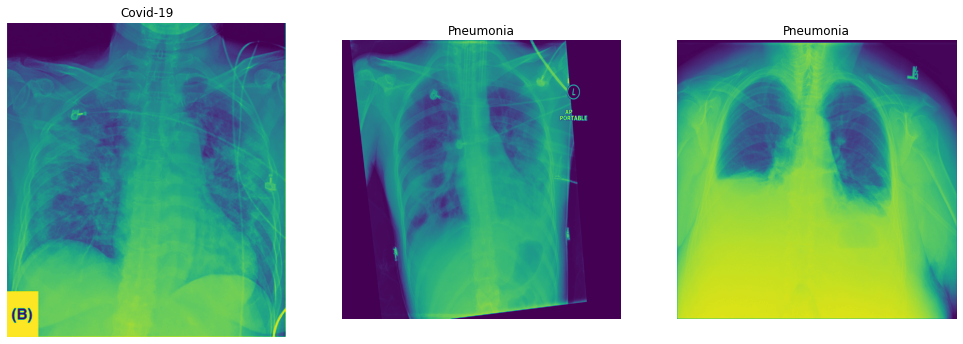

In [ ]:
# Let's see random images in our data
plt.figure(figsize =(17, 10))

for i in range(0,3):
  random_class_name = random.choice(species_list)
  random_image_name = random.choice(os.listdir(images_path + "/" + random_class_name))
  random_image_path = images_path + "/"+ random_class_name+ "/" + random_image_name
  plt.subplot(1, 3, i+1)
  img = plt.imread(random_image_path)  
  plt.title(random_class_name)
  plt.axis('off')
  plt.imshow(img)

plt.show()

## Data Preprocessing

In [8]:
def load_prep_image(filename, img_shape = 256):
  """
    Takes the images path and prepares the image to model for prediction.

    args:
      filename (str): images file path
      img_shape (int): images shape

    returns:
      adjusted version tensorflow tensor image for the model
  """

  # read in the image
  img = tf.io.read_file(filename)

  # decode the read file into a tensor
  img = tf.image.decode_image(img, channels = 1)
  
  # resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # rescale the image (get all values between 0 and 1)
  #img = img / 255.
  return img

In [64]:
def visualize_result(History, save_figure = False, name=None):
  """
    Takes the model and visualize the Accuracy, Validation accuracy, loss and Validation loss.

    args:
      model history (keras.callbacks.History): trained model.
      save_figure(str): if it is True it will save the plot (Default False)
      name(str): this attribute gives a name that you want to save the plot (Default= 'result_plot')
      directory(None): the path where the plot will be saved. (Default None)

    Returns:
      it returns a plot.
  
  """
  accuracy = History.history['accuracy']
  val_accuracy=History.history['val_accuracy']
  loss = History.history['loss']
  val_loss = History.history['val_loss']

  epochs = len(History.epoch)

  fig, (ax1,ax2) = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(15, 6))
  
  plot1 = ax1.plot(range(epochs),
                   accuracy,
                   label = 'accuracy')

  plot2 = ax1.plot(range(epochs),
                   val_accuracy,
                   label = 'val_accuracy')

  ax1.set(title = 'Accuracy & Validation accuracy',
          xlabel = 'epoch',
          ylabel = 'accuracy/ validation accuracy',
          #ylim = (0, 1)
          )
  
  ax1.legend()


  plot3 = ax2.plot(range(epochs),
                   loss,
                   label = 'loss')

  plot4 = ax2.plot(range(epochs),
                   val_loss,
                   label = 'val_loss')

  ax2.set(title = 'Loss & Validation loss',
          xlabel = 'epoch',
          ylabel = 'loss/ validation loss',
          #ylim = (0, 1)
          )
  
  ax2.legend()

  fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
  plt.tight_layout()

  if save_figure:
    plt.savefig(fname=name)
  plt.show();

In [ ]:
def split_data(img_path, saving_path, train_ratio, val_ratio, test_ratio, seed = 42):
  """
    Takes Images paths and split into folder format according to train, test, validation
    ratios.

    args:
      img_path (str): original images paths.
      saving_path (str): images destinations paths.
      train_ratio (int): train data percentage.
      val_ratio (int): validation data percentage.
      test_ratio (int): test data percentage.

    returns:
      this function returns a working directory based on the given variable 'saving_path'.
  """

  data = []
  species_list = []
  train_dir = saving_path + "train/"
  test_dir = saving_path + "test/"
  val_dir = saving_path + "val/"
  paths = [train_dir,test_dir,val_dir]
      
  try:
    os.makedirs(val_dir)
    print(f"{val_dir} file created ")
  except FileExistsError:
    print(f"{val_dir} file already exits)")
  try:
    os.makedirs(train_dir)
    print(f"{train_dir} file created ")
  except FileExistsError:
    print(f"{train_dir} file already exits)")
  try:
    os.makedirs(test_dir)
    print(f"{test_dir} file created ")
  except FileExistsError:
    print(f"{test_dir} file already exits)")

  for i in glob.glob(img_path + "/" + "*"):
    species_list.append(i.rsplit("/")[-1])
    data.append(glob.glob(i + "/" + "*"))

  # convert list to flat format  
  data = [item for sublist in data for item in sublist]
  
  
  for i in glob.glob(saving_path + "*"):
    for y in range(len(species_list)):
      species_name = i + "/" + species_list[y]
      try:
        os.makedirs(species_name)
        print(f"{species_name} file created")
      except FileExistsError:
        print(f"{species_name} file already exits")



  print("########### Train Test Val split Script started ###########")
  for cls in species_list:
      # Creating partitions of the data after shuffeling
      print("$$$$$$$ Class Name " + cls + " $$$$$$$")
      src = images_path +"/" + cls  # Folder to copy images from

      allFileNames = os.listdir(src)
      # set the random seed
      np.random.seed(seed)

      np.random.shuffle(allFileNames)
      train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - ((val_ratio/100) + (test_ratio/100)))),
                                                                   int(len(allFileNames) * (1 - (test_ratio/100))),
                                                                   ])

      train_FileNames = [src + '//' + name for name in train_FileNames.tolist()]
      val_FileNames = [src + '//' + name for name in val_FileNames.tolist()]
      test_FileNames = [src + '//' + name for name in test_FileNames.tolist()]

      print('Total images: '+ str(len(allFileNames)))
      print('Training: '+ str(len(train_FileNames)))
      print('Validation: '+  str(len(val_FileNames)))
      print('Testing: '+ str(len(test_FileNames)))


      # Copy-pasting images
      for name in train_FileNames:
        try:
          shutil.copy(name, train_dir + cls)
        except FileExistsError:
          continue

      for name in val_FileNames:
        try:
          shutil.copy(name, val_dir + cls)
        except FileExistsError:
          continue
      
      for name in test_FileNames:
        try:
          shutil.copy(name, test_dir + cls)
        except FileExistsError:
          continue

  print("########### Train Test Val split script Ended ###########")

In [ ]:
split_data(images_path,
           saving_path,
           train_ratio=80,
           val_ratio=10,
           test_ratio=10,
           seed =42)

/content/drive/MyDrive/Covid-proje/Covid-data/val/ file created 
/content/drive/MyDrive/Covid-proje/Covid-data/train/ file created 
/content/drive/MyDrive/Covid-proje/Covid-data/test/ file created 
/content/drive/MyDrive/Covid-proje/Covid-data/val/Pneumonia file created
/content/drive/MyDrive/Covid-proje/Covid-data/val/No_findings file created
/content/drive/MyDrive/Covid-proje/Covid-data/val/Covid-19 file created
/content/drive/MyDrive/Covid-proje/Covid-data/train/Pneumonia file created
/content/drive/MyDrive/Covid-proje/Covid-data/train/No_findings file created
/content/drive/MyDrive/Covid-proje/Covid-data/train/Covid-19 file created
/content/drive/MyDrive/Covid-proje/Covid-data/test/Pneumonia file created
/content/drive/MyDrive/Covid-proje/Covid-data/test/No_findings file created
/content/drive/MyDrive/Covid-proje/Covid-data/test/Covid-19 file created
########### Train Test Val split Script started ###########
$$$$$$$ Class Name Pneumonia $$$$$$$
Total images: 500
Training: 400
Vali

## Define Directiories

In [10]:
train_dir = "/content/drive/MyDrive/Covid-proje/Covid-data/train"
val_dir = "/content/drive/MyDrive/Covid-proje/Covid-data/val"
test_dir = "/content/drive/MyDrive/Covid-proje/Covid-data/test"

## Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Let's define train data generator
train_gen = ImageDataGenerator(rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

test_val_gen = ImageDataGenerator(rescale=1./255)

## Load the images

In [12]:
BATCH_SIZE = 32
IMG_SHAPE = (256, 256)
CHECKPOINT_FILEPATH = "/content/drive/MyDrive/Covid-proje/covid-data-checkpoints/"

In [13]:
train_data = train_gen.flow_from_directory(train_dir,
                                      target_size=IMG_SHAPE,
                                      color_mode='grayscale',
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE)

test_data = test_val_gen.flow_from_directory(test_dir,
                                        target_size=IMG_SHAPE,
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        shuffle=False,
                                        batch_size = BATCH_SIZE)

val_data = test_val_gen.flow_from_directory(val_dir,
                                            target_size=IMG_SHAPE,
                                            color_mode='grayscale',
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE)

Found 900 images belonging to 3 classes.
Found 113 images belonging to 3 classes.
Found 112 images belonging to 3 classes.


In [14]:
len(train_data.class_indices.keys())

3

## Define Callbacks

In [15]:
# Build EarlyStopping callback
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                       patience=20,  
                                                       verbose=1)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_FILEPATH,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='max',
                                                                save_best_only=True)

reduce_lr_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

In [16]:
# Sequential model
model_sequential_1 = tf.keras.Sequential([
                                tf.keras.layers.Convolution2D(32, 3, input_shape = (256, 256, 1), activation='relu'),              
                                tf.keras.layers.MaxPool2D(2),

                                tf.keras.layers.Convolution2D(32, 3, activation='relu'),
                                tf.keras.layers.MaxPool2D(2),


                                tf.keras.layers.Convolution2D(32, 3, activation='relu'),
                                tf.keras.layers.MaxPool2D(2),


                                tf.keras.layers.Convolution2D(32, 3, activation='relu'),
                                tf.keras.layers.MaxPool2D(2),

                                tf.keras.layers.Convolution2D(32, 3, activation='relu'),
                                tf.keras.layers.MaxPool2D(2),

                                tf.keras.layers.Convolution2D(32, 3, activation='relu'),
                                tf.keras.layers.MaxPool2D(2),

                                tf.keras.layers.Convolution2D(32, 2, activation='relu'),

                                 
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(32, activation='relu'),
                                tf.keras.layers.Dense(len(train_data.class_indices.keys()), activation = 'softmax', name= 'output_layer')
                                      ])

In [17]:
model_sequential_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

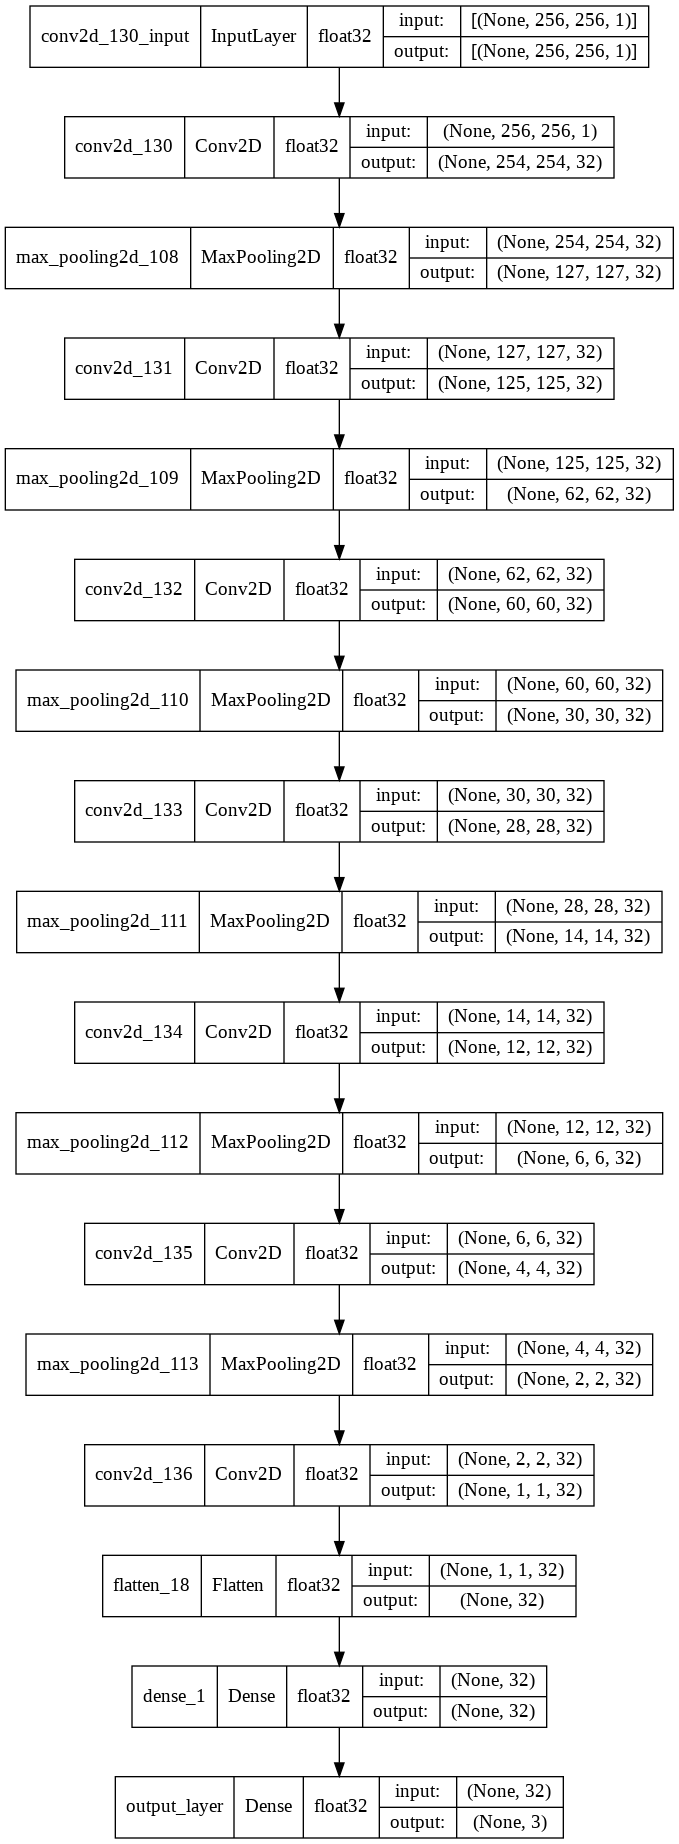

In [ ]:
tf.keras.utils.plot_model(model=model_sequential_1,
                          to_file='/content/drive/MyDrive/Covid-proje/model-architecture/model_architecture.png',
                          show_shapes=True,
                          show_dtype=True)

In [18]:
model_sequential_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

## Adjust the class weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_data.classes),
                                        y = train_data.classes                                                   
                                    )
class_weights = dict(zip(np.unique(train_data.classes), class_weights))
class_weights

{0: 3.0, 1: 0.75, 2: 0.75}

In [20]:
model_sequential_hist_1 = model_sequential_1.fit(train_data,
                                                steps_per_epoch = len(train_data),
                                                validation_data = val_data,
                                                validation_steps= len(val_data),
                                                callbacks = [model_checkpoint_callback],
                                                #class_weight=class_weights,
                                                epochs = 41)

Epoch 1/41
29/29 [==============================] - 151s 5s/step - loss: 1.0324 - accuracy: 0.4433 - val_loss: 0.9730 - val_accuracy: 0.5000
Epoch 2/41
29/29 [==============================] - 27s 937ms/step - loss: 0.9734 - accuracy: 0.4689 - val_loss: 0.9557 - val_accuracy: 0.4464
Epoch 3/41
29/29 [==============================] - 27s 933ms/step - loss: 0.9610 - accuracy: 0.4911 - val_loss: 0.9466 - val_accuracy: 0.4732
Epoch 4/41
29/29 [==============================] - 28s 981ms/step - loss: 0.9586 - accuracy: 0.4778 - val_loss: 0.9454 - val_accuracy: 0.6429
Epoch 5/41
29/29 [==============================] - 27s 941ms/step - loss: 0.8841 - accuracy: 0.6044 - val_loss: 0.8026 - val_accuracy: 0.6250
Epoch 6/41
29/29 [==============================] - 27s 947ms/step - loss: 0.8074 - accuracy: 0.6356 - val_loss: 0.8283 - val_accuracy: 0.5893
Epoch 7/41
29/29 [==============================] - 27s 936ms/step - loss: 0.7522 - accuracy: 0.6633 - val_loss: 0.7245 - val_accuracy: 0.6339
E

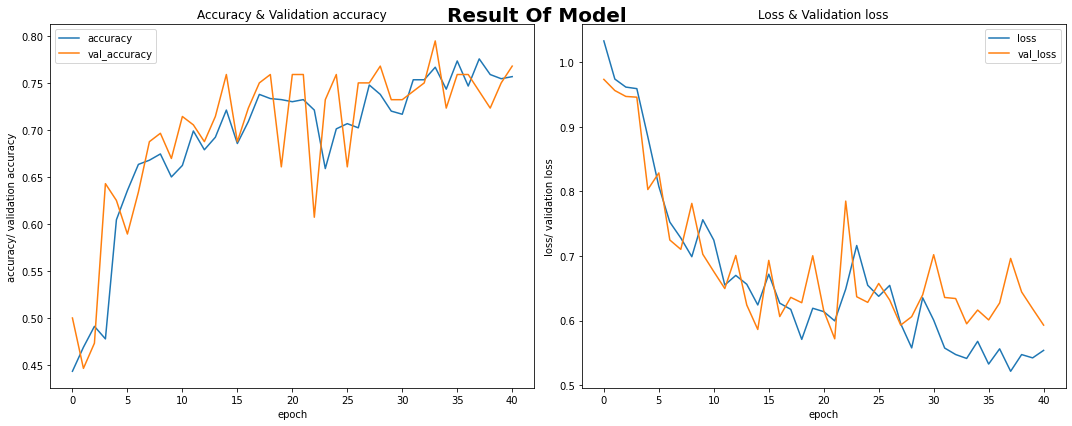

In [65]:
visualize_result(model_sequential_hist_1,
                save_figure="True",
                name = '/content/drive/MyDrive/Covid-proje/model-result/model-plot-result.png')

In [22]:
model_sequential_1.evaluate(val_data)

4/4 [==============================] - 2s 583ms/step - loss: 0.5929 - accuracy: 0.7679


[0.5928503274917603, 0.7678571343421936]

In [23]:
model_sequential_1.save(filepath='/content/drive/MyDrive/Covid-proje/covid-data-saved-model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Covid-proje/covid-data-saved-model/assets


In [24]:
random_species = random.choice(species_list)
filename = random.choice(os.listdir(test_dir + "/"+ random_species))
filepath = test_dir + "/" + random_species+ "/"+ filename

img = load_prep_image(filepath)

Text(0.5, 1.0, 'Covid-19')

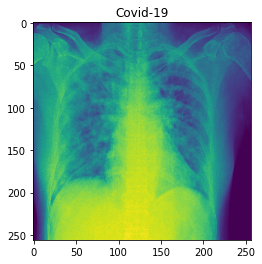

In [25]:
plt.imshow(tf.squeeze(img))
plt.title(random_species)

In [26]:
img = tf.expand_dims(img, axis = 0)
img.shape

TensorShape([1, 256, 256, 1])

In [27]:
model_sequential_1.predict(img)

array([[1., 0., 0.]], dtype=float32)

In [28]:
pred_prob = model_sequential_1.predict(img)
print(pred_prob)

[[1. 0. 0.]]


In [29]:
pred_class = species_list[pred_prob.argmax()]
pred_class

'Covid-19'

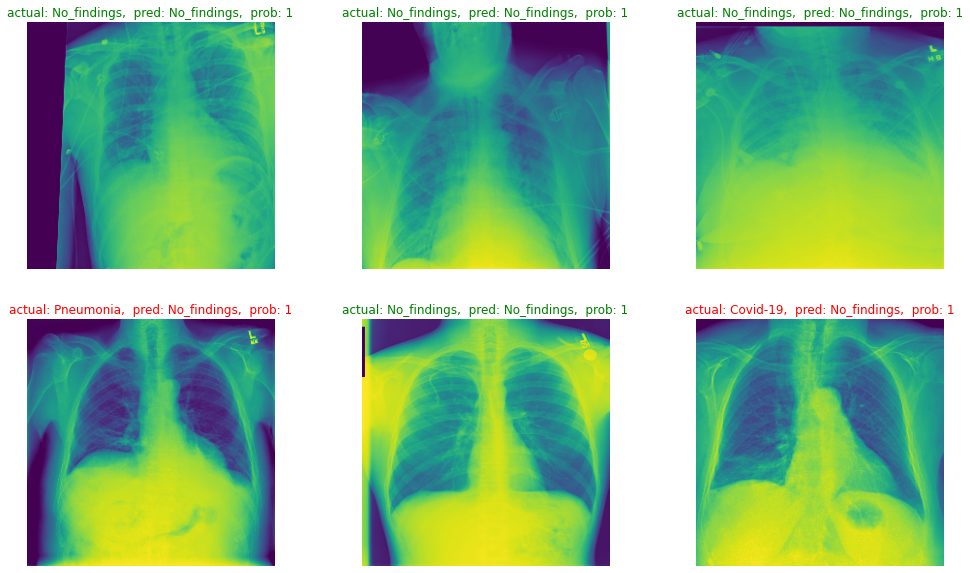

In [52]:
# Make preds on a series of random images 

plt.figure(figsize =(17, 10))

for i in range(6):
  # Choose random image(s) from random class(es)
  random_species = random.choice(species_list)
  filename = random.choice(os.listdir(test_dir + "/"+ random_species))
  filepath = test_dir + "/" + random_species+ "/"+ filename

  # Load image
  img = load_prep_image(filepath)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model_sequential_1.predict(img_expanded) # get prediction probabilities array
  pred_class = species_list[pred_prob.argmax()] # get highest prediction probability index
  #print(img_expanded.shape)
  #print(pred_prob)
  #print(pred_class)

  # plot the image(s)
  plt.subplot(2, 3, i+1)
  plt.imshow(tf.squeeze(img))
  if random_species == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {random_species},  pred: {pred_class},  prob: {pred_prob.argmax()}",c=title_color)
  plt.axis('off')

In [44]:
y_preds = model_sequential_1.predict(test_data)

In [45]:
test_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int32)

In [46]:
test_data.class_indices.keys()

dict_keys(['Covid-19', 'No_findings', 'Pneumonia'])

In [47]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
y_labels.append(test_data.classes)

tf.squeeze(y_labels[:10])

<tf.Tensor: shape=(113,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int32)>

In [48]:
pred_classes = y_preds.argmax(axis=1)
pred_classes

array([0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1,
       2, 2, 1])

In [49]:
confusion_matrix(y_true=tf.squeeze(y_labels),
                y_pred=pred_classes)

array([[10,  0,  3],
       [ 0, 41,  9],
       [ 1, 11, 38]])

In [50]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(tf.squeeze(y_true), y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed plot(x-labels vertically)
  plt.xticks(rotation=75, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("/content/drive/MyDrive/Covid-proje/model-result/confusion_matrix.png")


## Let's see the results

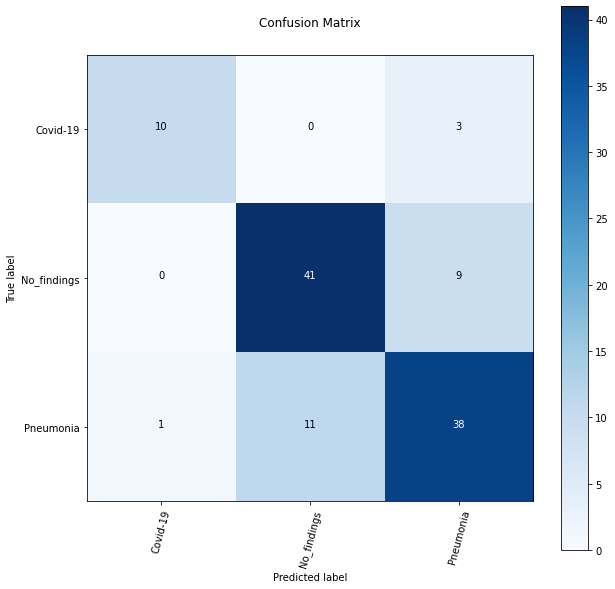

In [51]:
# Sequential_model_1
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_indices.keys(),
                      figsize=(10,10),
                      text_size=10,
                      savefig=True)